# Comprehending people’s responses through Facial Expression
--- 

## IDS 576 Deep Learning and Applications (41099), Fall 2022
--- 

## Group 3

### Tuhina (UIN 655777506)
### Trivikram Adurthi (UIN 655430082)
### Sahil Govardhan Limbasiya (UIN 659526504)  
### Anupriya Rastogi (UIN 671230155)

---
### Importing Libraries

In [1]:
#pip install torchvision
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/sem3 DL/project
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
/content/drive/MyDrive/sem3 DL/project


In [3]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting

In [4]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
#from deepface import DeepFace
import matplotlib.pyplot as plt

### Uploading the dataset

In [5]:
fer2013 = 'Datasets/fer2013.csv'
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
columns=['emotion','pixels','usage']
dataframe=pd.read_csv('Datasets/fer2013.csv',names=columns, na_filter=False)
image=dataframe['pixels']
dataframe.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [6]:
dataframe1 = pd.read_csv('Datasets/fer2013.csv')
#check data shape
dataframe1.shape
dataframe1.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [7]:
#check target labels
target_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
label_counts = dataframe1['emotion'].value_counts(sort=False).reset_index()
label_counts.columns = ['emotion', 'number']
label_counts['emotion'] = label_counts['emotion'].map(target_map)
label_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


### Plotting the Bar Graph for Number of Images for Each Emotion

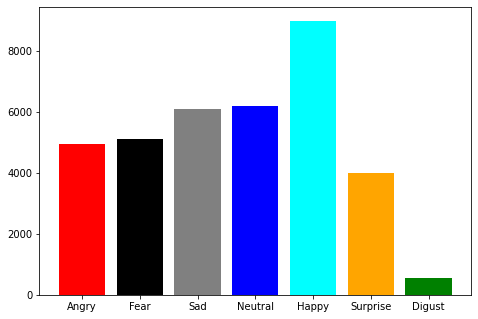

In [8]:
import matplotlib.pyplot as plt
figure = plt.figure()
axis = figure.add_axes([0,0,1,1])
emotion = label_counts['emotion']
total_num = label_counts['number']

# Create bars with different colors
plt.bar(emotion, total_num, color=['red', 'black', 'grey' , 'blue', 'cyan', 'orange', 'green'])


# Show graph
plt.show()

### Plotting some images from the dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


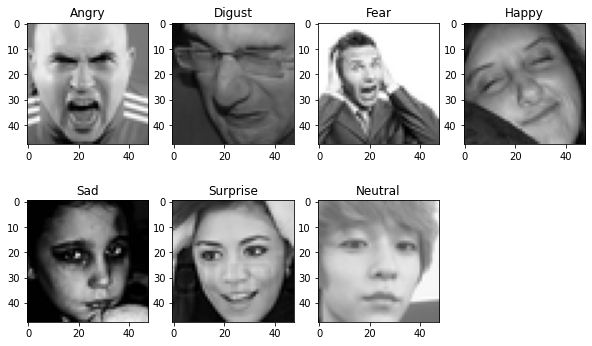

In [9]:
#Let's look at some images...

def row2image(row):
    pxl, emtn = row['pixels'], target_map[row['emotion']]
    _img_ = np.array(pxl.split())
    _img_ = _img_.reshape(48,48)
    imag = np.zeros((48,48,3))
    imag[:,:,0] = _img_
    imag[:,:,1] = _img_
    imag[:,:,2] = _img_
    return np.array([imag.astype(np.uint8), emtn])

plt.figure(0, figsize=(10,6))
for i in range(1,8):
    faces = dataframe1[dataframe1['emotion'] == i-1].iloc[3]
    _img_ = row2image(faces)
    plt.subplot(2,4,i)
    plt.imshow(_img_[0])
    plt.title(_img_[1])

plt.show()  

In [10]:
def getData(fer2013):
    # images are 48x48
    # X = 35887
    N = []
    M = []
    first = True
    for line in open(fer2013):
        if first:
            first = False
        else:
            row = line.split(',')
            N.append(int(row[0]))
            M.append([int(p) for p in row[1].split()])

    M, N = np.array(M) / 255.0, np.array(N)
    return M, N

In [11]:
M, N = getData(fer2013)
num_class = len(set(N))
print(num_class)

7


In [12]:
X, D = M.shape
M = M.reshape(X, 48, 48, 1)

---
## Facial Feature Extraction Using Haar Cascade Method
--- 

### Eyes and Face Annotation For An Individual Picture

In [13]:
def annotate(_img_):
    Cascade_face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    Cascade_eye = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray_color = cv2.cvtColor(_img_, cv2.COLOR_BGR2GRAY)
    face_image = Cascade_face.detectMultiScale(gray_color, 1.3, 5)
    print('Number of faces detected:', len(face_image))
    for (x, y, w, h) in face_image:
        cv2.rectangle(_img_, (x,y) , (x+w, y+h) , (0,255,0) , 4)
    eyes_image = Cascade_eye.detectMultiScale(gray_color, 1.3, 5)
    print('Number of eyes detected:', len(eyes_image))
    for (ex,ey,ew,eh) in eyes_image:
        cv2.rectangle(_img_,(ex,ey),(ex+ew,ey+eh),(0,255,0),4)

    plt.imshow(cv2.cvtColor(_img_, cv2.COLOR_BGR2RGB))

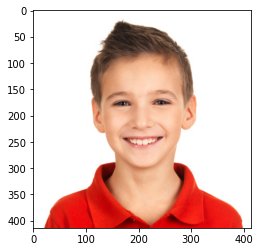

In [14]:
_img__happy=cv2.imread("Images/happy.jpeg")
plt.imshow(cv2.cvtColor(_img__happy, cv2.COLOR_BGR2RGB))

Number of faces detected: 1
Number of eyes detected: 2


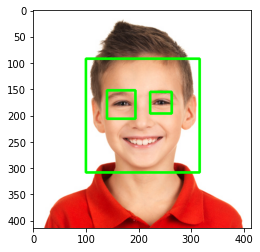

In [15]:
annotate(_img__happy)

### Eyes and Face Annotation For Group Pictures

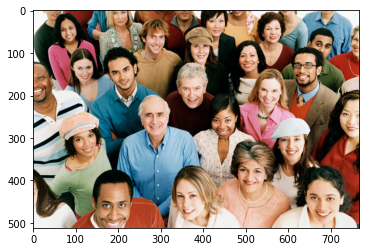

In [16]:
_img_=cv2.imread("Images/team.jpeg")
plt.imshow(cv2.cvtColor(_img_, cv2.COLOR_BGR2RGB))

Number of faces detected: 18
Number of eyes detected: 15


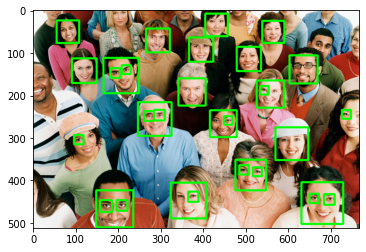

In [17]:
annotate(_img_)

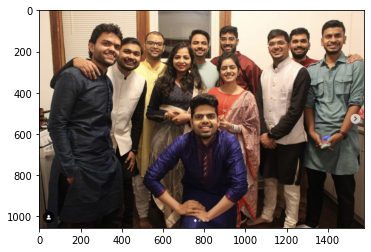

In [18]:
img1=cv2.imread("Images/Diwali.png")
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

Number of faces detected: 13
Number of eyes detected: 5


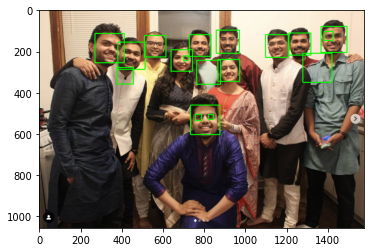

In [19]:
annotate(img1)

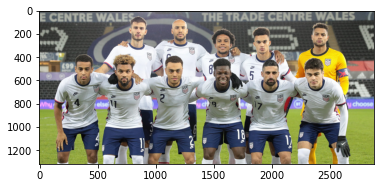

In [20]:
img_mnt=cv2.imread("Images/MNT.jpeg")
plt.imshow(cv2.cvtColor(img_mnt, cv2.COLOR_BGR2RGB))

Number of faces detected: 10
Number of eyes detected: 19


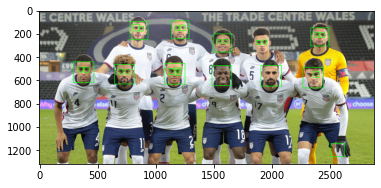

In [21]:
annotate(img_mnt)

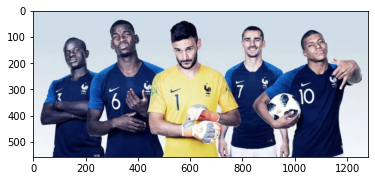

In [22]:
mg_fnt=cv2.imread("Images/FNT.jpeg")
plt.imshow(cv2.cvtColor(mg_fnt, cv2.COLOR_BGR2RGB))

Number of faces detected: 2
Number of eyes detected: 3


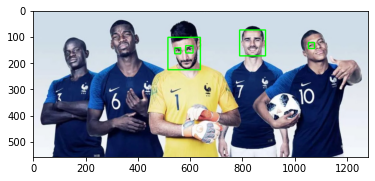

In [23]:
annotate(mg_fnt)

### Facial and Eyes Annotation For Images in Our Dataset

In [24]:
def annotate_1(_img_):
    Cascade_face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    Cascade_eye = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray_color = cv2.cvtColor(_img_, cv2.COLOR_BGR2GRAY)
    face_image = Cascade_face.detectMultiScale(gray_color, 1.3, 5)
    for (x, y, w, h) in face_image:
        cv2.rectangle(_img_, (x,y) , (x+w, y+h) , (0,255,0) , 4)
    eyes_image = Cascade_eye.detectMultiScale(gray_color, 1.3, 5)
    for (ex,ey,ew,eh) in eyes_image:
        cv2.rectangle(_img_,(ex,ey),(ex+ew,ey+eh),(0,255,0),4)

    plt.imshow(cv2.cvtColor(_img_, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


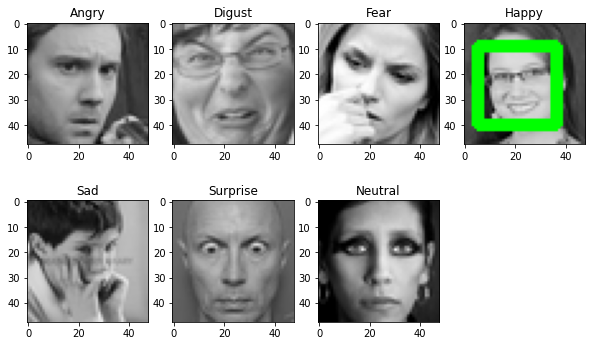

In [25]:
#Let's look at some images...

def row2image(row):
    pxl, emtn = row['pixels'], target_map[row['emotion']]
    _img_ = np.array(pxl.split())
    _img_ = _img_.reshape(48,48)
    imag = np.zeros((48,48,3))
    imag[:,:,0] = _img_
    imag[:,:,1] = _img_
    imag[:,:,2] = _img_
    return np.array([imag.astype(np.uint8), emtn])

plt.figure(0, figsize=(10,6))
for i in range(1,8):
    faces = dataframe1[dataframe1['emotion'] == i-1].iloc[0]
    _img_ = row2image(faces)
    plt.subplot(2,4,i)
    annotate_1(_img_[0])
    plt.imshow(cv2.cvtColor(_img_[0], cv2.COLOR_BGR2RGB))
    plt.title(_img_[1])

plt.show() 

---
## Creating the CNN Model and Predicting the Emotions
---

### Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split

m_train, m_test, n_train, n_test = train_test_split(M, N, test_size=0.1, random_state=0)
n_train = (np.arange(num_class) == n_train[:, None]).astype(np.float32)
n_test = (np.arange(num_class) == n_test[:, None]).astype(np.float32)

In [14]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization

In [15]:
def my_model():
    modeling = Sequential()
    input_shape = (48,48,1)
    modeling.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    modeling.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    modeling.add(BatchNormalization())
    modeling.add(MaxPooling2D(pool_size=(2, 2)))

    modeling.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    modeling.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    modeling.add(BatchNormalization())
    modeling.add(MaxPooling2D(pool_size=(2, 2)))

    modeling.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    modeling.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    modeling.add(BatchNormalization())
    modeling.add(MaxPooling2D(pool_size=(2, 2)))

    modeling.add(Flatten())
    modeling.add(Dense(128))
    modeling.add(BatchNormalization())
    modeling.add(Activation('relu'))
    modeling.add(Dropout(0.2))
    modeling.add(Dense(7))
    modeling.add(Activation('softmax'))
    
    modeling.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return modeling
modeling=my_model()
modeling.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       4

In [16]:
from keras import backend as K
import random
path_modeling='Datasets/model_filter.h5' # save model at this location after each epoch
tf.compat.v1.keras.backend.clear_session() # destroys the current graph and builds a new one
modeling=my_model() # create the model
K.set_value(modeling.optimizer.lr,1e-3) # set the learning rate
# fit the model
random.seed(10)
h=modeling.fit(x=m_train,     
            y=n_train,
            batch_size=64, 
            epochs=10, 
            verbose=1, 
            validation_data=(m_test,n_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_modeling),
            ]
            )

Epoch 1/10
505/505 [==============================] - 30s 42ms/step - loss: 1.6533 - accuracy: 0.3588 - val_loss: 1.4976 - val_accuracy: 0.4216
Epoch 2/10
505/505 [==============================] - 19s 38ms/step - loss: 1.3021 - accuracy: 0.5039 - val_loss: 1.2567 - val_accuracy: 0.5213
Epoch 3/10
505/505 [==============================] - 20s 39ms/step - loss: 1.1232 - accuracy: 0.5772 - val_loss: 1.3115 - val_accuracy: 0.5054
Epoch 4/10
505/505 [==============================] - 19s 39ms/step - loss: 0.9986 - accuracy: 0.6262 - val_loss: 1.2123 - val_accuracy: 0.5570
Epoch 5/10
505/505 [==============================] - 20s 40ms/step - loss: 0.8792 - accuracy: 0.6719 - val_loss: 1.1789 - val_accuracy: 0.5690
Epoch 6/10
505/505 [==============================] - 20s 39ms/step - loss: 0.7535 - accuracy: 0.7231 - val_loss: 1.1225 - val_accuracy: 0.5968
Epoch 7/10
505/505 [==============================] - 20s 40ms/step - loss: 0.5990 - accuracy: 0.7825 - val_loss: 1.2432 - val_accuracy:

In [17]:
objct = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
n_pos = np.arange(len(objct))

def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    n_pos = np.arange(len(objects))
    plt.bar(n_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(n_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [18]:
from keras.models import load_model

In [19]:
#from keras.models import load_model
modeling =load_model(r'Datasets/model_filter.h5')

n_pred=modeling.predict(m_test)
#print(y_pred)
n_test.shape

113/113 [==============================] - 1s 6ms/step


(3589, 7)

### Predicting the Emotions from an Individual Image Uploaded Externally

1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.7/dist-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


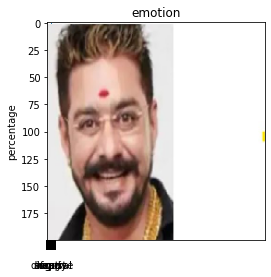

Expression Prediction: happy


In [43]:
from skimage import io
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
_img_ = load_img('Images/hb_happy.jpg', grayscale=True, target_size=(48, 48))
show_img=load_img('Images/hb_happy.jpg', grayscale=False, target_size=(200, 200))
m = img_to_array(_img_)
m = np.expand_dims(m, axis = 0)

m /= 255

custom = modeling.predict(m)
#print(custom[0])
emotion_analysis(custom[0])

m = np.array(m, 'float32')
m = m.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

decimal=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>decimal:
        decimal=a[i]
        ind=i
        
print('Expression Prediction:',objct[ind])

1/1 [==============================] - 0s 17ms/step


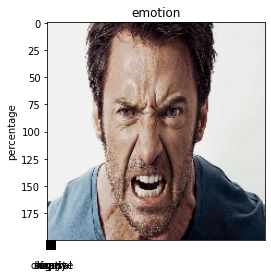

Expression Prediction: angry


In [44]:
from skimage import io
_img_ = load_img('Images/angry.jpg', grayscale=True, target_size=(48, 48))
show_img=load_img('Images/angry.jpg', grayscale=False, target_size=(200, 200))
m = img_to_array(_img_)
m = np.expand_dims(m, axis = 0)

m /= 255

custom = modeling.predict(m)
#print(custom[0])
emotion_analysis(custom[0])

m = np.array(m, 'float32')
m = m.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

decimal=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>decimal:
        decimal=a[i]
        ind=i
        
print('Expression Prediction:',objct[ind])


### Predicting the Emotions from Group Image Uploaded Externally

1/1 [==============================] - 0s 21ms/step


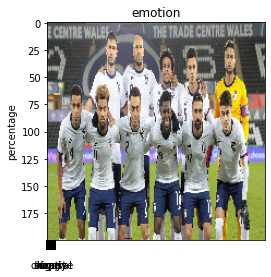

Expression Prediction: sad


In [45]:
from skimage import io
_img_ = load_img('Images/MNT.jpeg', grayscale=True, target_size=(48, 48))
show_img=load_img('Images/MNT.jpeg', grayscale=False, target_size=(200, 200))
m = img_to_array(_img_)
m = np.expand_dims(m, axis = 0)

m /= 255

custom = modeling.predict(m)
#print(custom[0])
emotion_analysis(custom[0])

m = np.array(m, 'float32')
m = m.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

decimal=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>decimal:
        decimal=a[i]
        ind=i
        
print('Expression Prediction:',objct[ind])


### Finding the Accuracy For CNN Model

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
testing_true = np.argmax(n_test, axis=1)
testing_pred = np.argmax(n_pred, axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(testing_true, testing_pred)))

CNN Model Accuracy on test set: 0.6225


### Plotting the Confusion Matrix For CNN Model

In [47]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

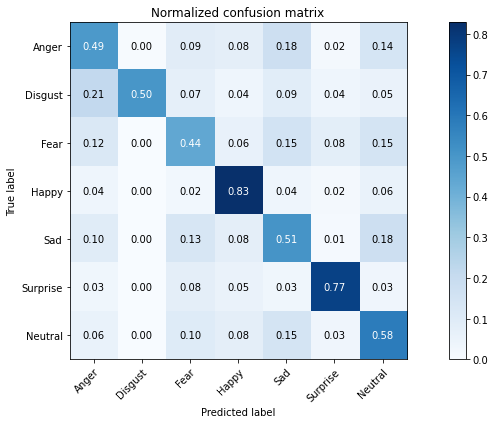

In [48]:
# Plot normalized confusion matrix
plot_confusion_matrix(testing_true, testing_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

---
## Creating the SVM Model and Predicting the Emotions
---

In [78]:
import math
import numpy as np
import pandas as pd
import time
from sklearn.svm import SVC
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [79]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
columns=['emotion','pixels','usage']
dataframe_svm=pd.read_csv('Datasets/fer2013.csv')

In [80]:
target_label = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [81]:
dataframe_svm.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [82]:
#Input and Output Data
M = dataframe_svm.pixels.apply(lambda x: np.array(x.split(' ')).astype('float32'))
M = np.stack(M, axis=0)
N = np.array(dataframe_svm['emotion'])

In [83]:
M.shape

(35887, 2304)

In [84]:
N.shape

(35887,)

In [85]:
cascade_face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cascade_eye = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [86]:
def face_align(gray_image):
  size = gray_image.shape
  # Creating variable eyes
  eye_detect  = cascade_eye.detectMultiScale(gray_image, 1.3, 5)
  if len(eye_detect) > 1 :
    index=0
    # Creating for loop in order to divide one eye from another
    for (ex , ey,  ew,  eh) in eye_detect:
      if index == 0:
        eye1 = (ex, ey, ew, eh)
      elif index == 1:
        eye2 = (ex, ey, ew, eh)
      index += 1
    if eye1[0] < eye2[0]:
      lefteye = eye1
      righteye = eye2
    else:
      lefteye = eye2
      righteye = eye1
        
    # Calculating coordinates of a central points of the rectangles
    lefteye_center = (int(lefteye[0] + (lefteye[2] / 2)), int(lefteye[1] + (lefteye[3] / 2)))
    lefteye_x = lefteye_center[0] 
    lefteye_y = lefteye_center[1]
        
    righteye_center = (int(righteye[0] + (righteye[2]/2)), int(righteye[1] + (righteye[3]/2)))
    righteye_x = righteye_center[0]
    righteye_y = righteye_center[1]

    if lefteye_y > righteye_y:
      A = (righteye_x, lefteye_y)
      # Integer -1 indicates that the image will rotate in the clockwise direction
      drtn = -1 
    else:
      A = (lefteye_x, righteye_y)
      # Integer 1 indicates that image will rotate in the counter clockwise direction
      drtn = 1 
        
    delta_x = righteye_x - lefteye_x
    delta_y = righteye_y - lefteye_y
    angle=np.arctan(delta_y/delta_x)
    angle = (angle * 180) / np.pi

    # Width and height of the image
    height, width = gray_image.shape[:2]
    # Calculating a center point of the image
    # Integer division "//"" ensures that we receive whole numbers
    center = (width // 2, height // 2)
    # Defining a matrix M and calling
    # cv2.getRotationMatrix2D method
    Matrix = cv2.getRotationMatrix2D(center, (angle), 1.0)
    # Applying the rotation to our image using the
    # cv2.warpAffine method
    gray_image = cv2.warpAffine(gray_image, Matrix, (width, height))

    #Again detecting face
    faces = cascade_face.detectMultiScale(gray_image, 1.3, 5)
    if len(faces) > 0 : 
      (x,y,width,height) = faces[0]
      gray_image = gray_image[y:y+height, x:x+width]

  gray_image = cv2.resize(gray_image,size) 
  return gray_image

In [87]:
M_new = []
for j in range(M.shape[0]):
  pm = np.array(M[j]).reshape(48,48)
  pm = np.array(pm, dtype='uint8')
  pm = face_align(pm)
  M_new.append(np.array(pm).reshape(48*48))
M = np.array(M_new)

In [89]:
m_train, m_valid, n_train, n_valid = train_test_split(M, N,
                                                    shuffle=True, stratify=N,
                                                    test_size=0.2, random_state=2)
m_train.shape, m_valid.shape, n_train.shape, n_valid.shape

((28709, 2304), (7178, 2304), (28709,), (7178,))

In [90]:
#PCA to retain 95% variation and reduce dataset size
scaleling = StandardScaler()
m_train = scaleling.fit_transform(m_train.astype(np.float32))
m_valid = scaleling.transform(m_valid.astype(np.float32))
Principal_component_analysis = PCA(n_components=.95)
Principal_component_analysis.fit(m_train)
m_test_p = Principal_component_analysis.transform(m_valid)
m_train_p = Principal_component_analysis.transform(m_train)
scaleling = StandardScaler()
m_train_p = scaleling.fit_transform(m_train_p.astype(np.float32))
m_test_p = scaleling.transform(m_test_p.astype(np.float32))
m_train_p.shape ,m_test_p.shape 

((28709, 269), (7178, 269))

In [91]:
#Using rbf kernel
modeling = SVC(kernel ='rbf')
modeling.fit(m_train_p, n_train)
modeling.score(m_test_p , n_valid)

0.4605739760378936

In [92]:
n_pred=modeling.predict(m_test_p)
print(n_pred)

[0 3 0 ... 3 5 6]


In [ ]:
random_state = 0
epochs = 10000
kernel = 'rbf'  # 'rbf', 'linear', 'poly' or 'sigmoid'
decision_function = 'ovr'  # 'ovo' for OneVsOne and 'ovr' for OneVsRest'
   
svm_modeling = SVC(random_state=random_state, max_iter=epochs, kernel=kernel, decision_function_shape=decision_function)
svm_modeling.fit(m_train_p, n_train)

In [ ]:
svm_modeling.score(m_test_p , n_valid)

In [ ]:
n_pred=svm_modeling.predict(m_test_p) 

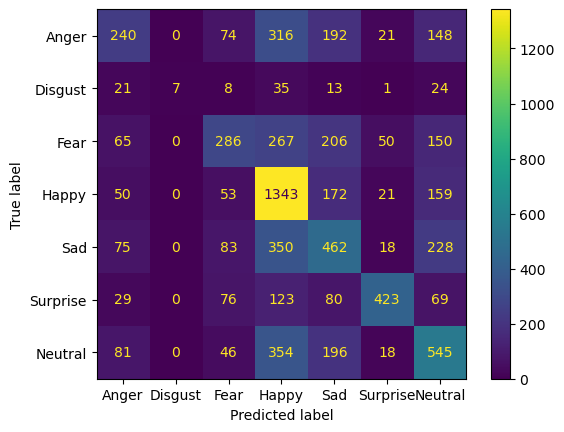

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
c_matrix = confusion_matrix(n_valid, n_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=emotion_mapping)
disp.plot()
plt.show()

In [ ]:
label = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
n_pos = np.arange(len(label))
print(n_pos)

[0 1 2 3 4 5 6]


In [ ]:
len(n_pred)

7178

In [ ]:
M.shape

(35887, 2304)

In [ ]:
m_image = m_valid.reshape(7178,48,48)

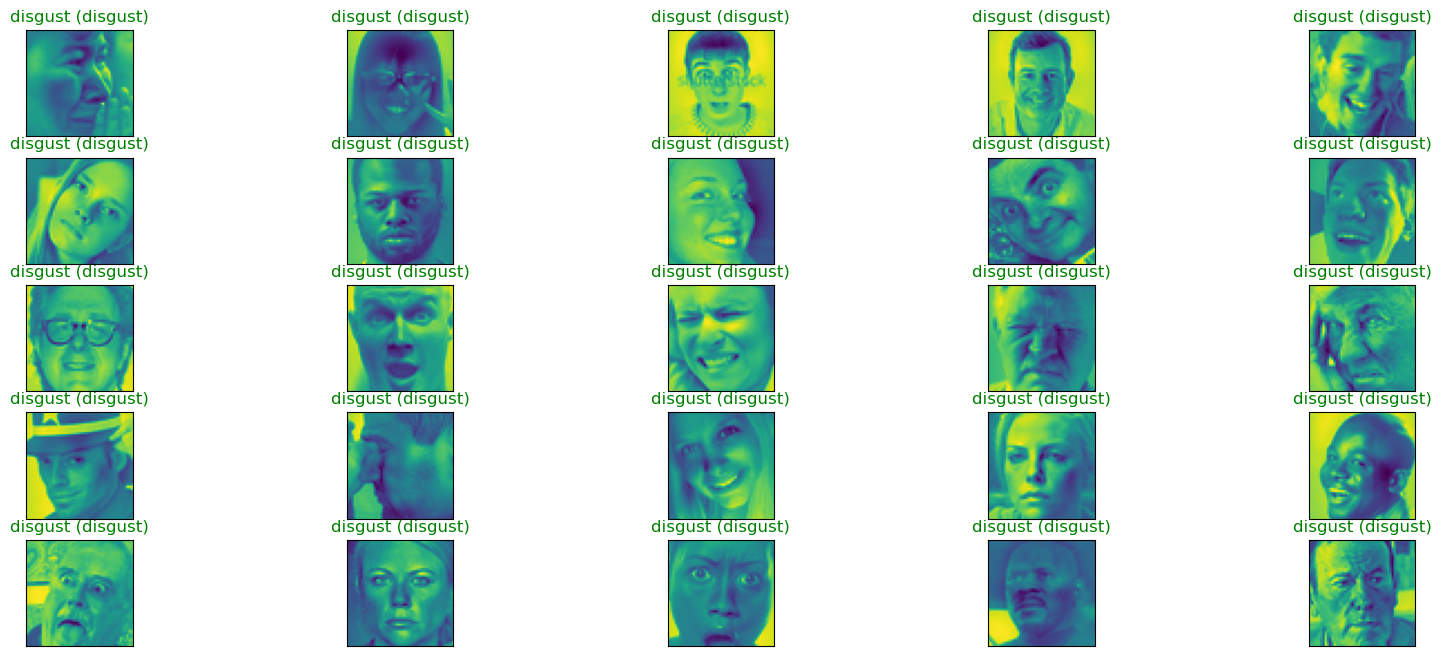

In [ ]:
Facelabels =['disgust', 'anger', 'sadness', 'surprise', 'contempt', 'fear', 'happy']

#y_pred=y_pred.reshape(269,269)
#predictedExpression = svm_model.predict(y_pred)

fig = plt.figure(figsize=(20, 8))

for i, indx in enumerate(np.random.choice(m_image.shape[0], size=25, replace=False)):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(m_image[indx]))
    predicted_indx = np.argmax(n_pred[indx])
    true_indx = np.argmax(N[indx])
    # Set the title for each image
    ax.set_title("{} ({})".format(Facelabels[predicted_indx], 
                                  Facelabels[true_indx]),
                                  color=("green" if predicted_indx == true_indx else "red"))
plt.show()

---
## Creating the Deepface Model and Predicting the Emotions
---

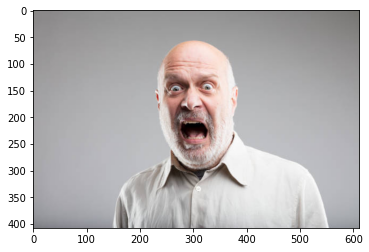

In [38]:
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt

image_deep=cv2.imread("Images/fear.jpeg")
plt.imshow(cv2.cvtColor(image_deep,cv2.COLOR_BGR2RGB))

In [35]:
#pip install deepface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 1.2 MB/s 
     |████████████████████████████████| 2.3 MB 6.6 MB/s 
     |████████████████████████████████| 87 kB 1.1 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=a1dbc2f743291233ea13df04fd50b0f6a6b6bf0d1e0a1a5d542c727cb3010bcc
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


### Predicting the Emotions for An Individual Picture

In [39]:
predicted=DeepFace.analyze(image_deep)

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:01<00:00, 5.80MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [01:21<00:00, 6.58MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:44<00:00, 12.0MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [01:14<00:00, 7.26MB/s]
Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 117ms/step


Action: age:  25%|██▌       | 1/4 [00:00<00:00,  3.16it/s]    

1/1 [==============================] - 1s 818ms/step


Action: gender:  50%|█████     | 2/4 [00:01<00:01,  1.44it/s]

1/1 [==============================] - 1s 784ms/step


Action: race:  75%|███████▌  | 3/4 [00:02<00:00,  1.32it/s]  

1/1 [==============================] - 1s 775ms/step


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


In [40]:
predicted

{'emotion': {'angry': 13.935603201389313,
  'disgust': 0.00022055876343074488,
  'fear': 84.52951908111572,
  'happy': 0.01837500894907862,
  'sad': 0.06634408491663635,
  'surprise': 1.4498407021164894,
  'neutral': 9.879324807116063e-05},
 'dominant_emotion': 'fear',
 'region': {'x': 224, 'y': 84, 'w': 150, 'h': 150},
 'age': 28,
 'gender': 'Man',
 'race': {'asian': 1.2387879192829132,
  'indian': 6.706368923187256,
  'black': 75.13997554779053,
  'white': 1.859944500029087,
  'middle eastern': 0.874685775488615,
  'latino hispanic': 14.180237054824829},
 'dominant_race': 'black'}

In [41]:
predicted['dominant_emotion']

'fear'

In [42]:
predicted['age']

28

In [43]:
predicted['dominant_race']

'black'

In [44]:
predicted['gender']

'Man'

Number of faces detected: 1
Number of eyes detected: 2


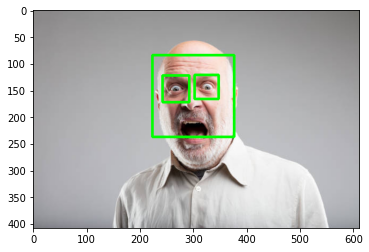

In [45]:
annotate(image_deep)

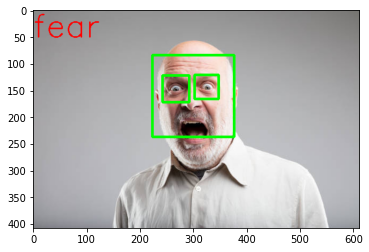

In [46]:
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(image_deep,
            predicted['dominant_emotion'],
            (0,50),
            font, 2,
            (0,0,255),
            2,);
plt.imshow(cv2.cvtColor(image_deep, cv2.COLOR_BGR2RGB))

### Predicting the Emotions for A Group Picture

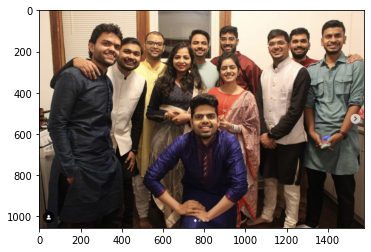

In [62]:
image_deep_grp=cv2.imread("Images/Diwali.png")
plt.imshow(cv2.cvtColor(image_deep_grp,cv2.COLOR_BGR2RGB))

In [63]:
predicted=DeepFace.analyze(image_deep_grp)

Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Action: age:  25%|██▌       | 1/4 [00:01<00:04,  1.43s/it]    

1/1 [==============================] - 1s 650ms/step


Action: gender:  50%|█████     | 2/4 [00:03<00:03,  1.79s/it]

1/1 [==============================] - 1s 714ms/step


Action: race:  75%|███████▌  | 3/4 [00:04<00:01,  1.58s/it]  

1/1 [==============================] - 1s 671ms/step


Action: race: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


In [64]:
predicted['dominant_emotion']

'happy'

Number of faces detected: 13
Number of eyes detected: 5


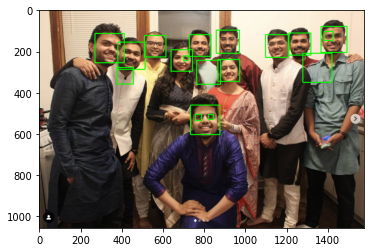

In [65]:
annotate(image_deep_grp)

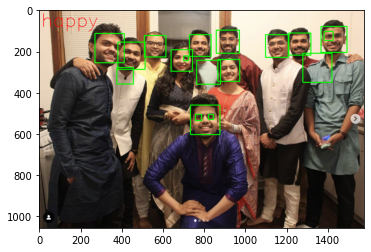

In [66]:
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(image_deep_grp,
            predicted['dominant_emotion'],
            (10,80),
            font, 3,
            (0,0,255),
            2,);
plt.imshow(cv2.cvtColor(image_deep_grp, cv2.COLOR_BGR2RGB))

---
##  Manipulating the images using PIL (pillow) and Predicting the Emotions For Deepface
---

### Resizing the Image to 48 * 48

In [67]:
image = Image.open('Images/happy.jpeg')
new_image = image.resize((48, 48))
new_image.save('Images/myimage.jpeg')

### Adjusting the brightness of the image

#### Now, we will brighten the image with a factor of 1, which gives our original image. Then with a factor of 1.5, which gives a brightened image. And then with a factor of 0.5, which gives a darkened image.

In [68]:
from PIL import Image, ImageEnhance

#read the image
image = Image.open("Images/myimage.jpeg")

#image brightness enhancer
enhancer = ImageEnhance.Brightness(image)

factor = 1 #gives original image
image_output = enhancer.enhance(factor)
image_output.save('Brightness/original-image.jpeg')

factor = 0.5 #darkens the image
image_output = enhancer.enhance(factor)
image_output.save('Brightness/darkened-image.jpeg')

factor = 1.5 #brightens the image
image_output = enhancer.enhance(factor)
image_output.save('Brightness/brightened-image.jpeg')

### Adjusting the contrast of the image


#### Now, we will change the image contrast with a factor of 1, which gives our original image. Then with a factor of 1.5, which increases the image’s contrast. And then with a factor of 0.5, which greys out the image.

In [69]:
#read the image
image = Image.open("Images/myimage.jpeg")

#image brightness enhancer
enhancer = ImageEnhance.Contrast(image)

factor = 1 #gives original image
image_output = enhancer.enhance(factor)
image_output.save('Contrast/original-image.jpeg')

factor = 0.5 #decrease constrast
image_output = enhancer.enhance(factor)
image_output.save('Contrast/less-contrast-image.jpeg')

factor = 1.5 #increase contrast
image_output = enhancer.enhance(factor)
image_output.save('Contrast/more-contrast-image.jpeg')

### Adjusting the sharpness of the image


#### Now, we will sharpen the image with a factor of 1, which gives our original image. Then with a factor of 2, which gives a sharpened image. And then with a factor of 0.05, which gives a blurred image.

In [70]:
from PIL import Image, ImageEnhance

image = Image.open("Images/myimage.jpeg")

enhancer = ImageEnhance.Sharpness(image)

factor = 1
image_s_1 = enhancer.enhance(factor)
image_s_1.save('Sharpness/original-image-1.jpeg');

factor = 0.05
image_s_1 = enhancer.enhance(factor)
image_s_1.save('Sharpness/blurred-image.jpeg');

factor = 2
image_s_1 = enhancer.enhance(factor)
image_s_1.save('Sharpness/sharpened-image.jpeg');

## Checking all the Manipulated Images with Deepface
---

### Brightness
---

#### Brightness: Using Deepface for Less Brightened Images

Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Action: age:   0%|          | 0/4 [00:00<?, ?it/s]    

1/1 [==============================] - 1s 645ms/step


Action: gender:  50%|█████     | 2/4 [00:00<00:00,  2.56it/s]

1/1 [==============================] - 1s 646ms/step


Action: race:  75%|███████▌  | 3/4 [00:01<00:00,  1.92it/s]  

1/1 [==============================] - 1s 639ms/step


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Number of faces detected: 1
Number of eyes detected: 0


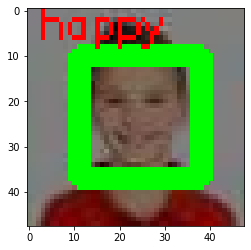

In [71]:
image_brt=cv2.imread("Brightness/darkened-image.jpeg")
predicted=DeepFace.analyze(image_brt)
annotate(image_brt)
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(image_brt,
            predicted['dominant_emotion'],
            (2,6),
            font, 0.3,
            (0,0,255),
            0,);
plt.imshow(cv2.cvtColor(image_brt, cv2.COLOR_BGR2RGB))

#### Brightness: Using Deepface for More Brightened Images

Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Action: age:   0%|          | 0/4 [00:00<?, ?it/s]    

1/1 [==============================] - 1s 638ms/step


Action: gender:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

1/1 [==============================] - 1s 654ms/step


Action: race:  75%|███████▌  | 3/4 [00:01<00:00,  1.94it/s]  

1/1 [==============================] - 1s 625ms/step


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Number of faces detected: 1
Number of eyes detected: 0


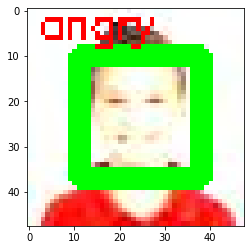

In [73]:
image_brt1=cv2.imread("Brightness/brightened-image.jpeg")
predicted=DeepFace.analyze(image_brt1)
annotate(image_brt1)
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(image_brt1,
            predicted['dominant_emotion'],
            (2,6),
            font, 0.3,
            (0,0,255),
            0,);
plt.imshow(cv2.cvtColor(image_brt1, cv2.COLOR_BGR2RGB))

### Contrast
---

#### Contrast: Using Deepface for Less Contrast Images

Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Action: age:   0%|          | 0/4 [00:00<?, ?it/s]    

1/1 [==============================] - 1s 641ms/step


Action: gender:  50%|█████     | 2/4 [00:00<00:00,  2.65it/s]

1/1 [==============================] - 1s 634ms/step


Action: race:  75%|███████▌  | 3/4 [00:01<00:00,  1.99it/s]  

1/1 [==============================] - 1s 615ms/step


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

Number of faces detected: 1
Number of eyes detected: 0


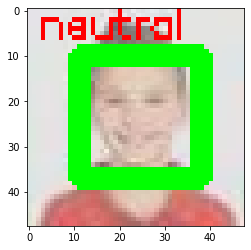

In [74]:
image_cnt=cv2.imread("Contrast/less-contrast-image.jpeg")
predicted=DeepFace.analyze(image_cnt)
annotate(image_cnt)
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(image_cnt,
            predicted['dominant_emotion'],
            (2,6),
            font, 0.3,
            (0,0,255),
            0,);
plt.imshow(cv2.cvtColor(image_cnt, cv2.COLOR_BGR2RGB))

#### Contrast: Using Deepface for More Contrast Images

Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Action: age:   0%|          | 0/4 [00:00<?, ?it/s]    

1/1 [==============================] - 1s 635ms/step


Action: gender:  50%|█████     | 2/4 [00:00<00:00,  2.64it/s]

1/1 [==============================] - 1s 637ms/step


Action: race:  75%|███████▌  | 3/4 [00:01<00:00,  1.97it/s]  

1/1 [==============================] - 1s 633ms/step


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

Number of faces detected: 1
Number of eyes detected: 0


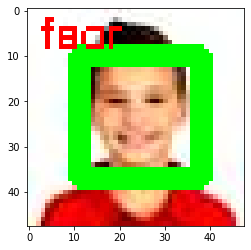

In [75]:
image_cnt1=cv2.imread("Contrast/more-contrast-image.jpeg")
predicted=DeepFace.analyze(image_cnt1)
annotate(image_cnt1)
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(image_cnt1,
            predicted['dominant_emotion'],
            (2,8),
            font, 0.3,
            (0,0,255),
            0,);
plt.imshow(cv2.cvtColor(image_cnt1, cv2.COLOR_BGR2RGB))

### Sharpness
---

#### Sharpness: Using Deepface for Less Sharper Images

Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


Action: age:  25%|██▌       | 1/4 [00:00<00:01,  2.32it/s]    

1/1 [==============================] - 1s 643ms/step


Action: gender:  50%|█████     | 2/4 [00:01<00:01,  1.70it/s]

1/1 [==============================] - 1s 631ms/step


Action: race:  75%|███████▌  | 3/4 [00:01<00:00,  1.58it/s]  

1/1 [==============================] - 1s 627ms/step


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

Number of faces detected: 1
Number of eyes detected: 0


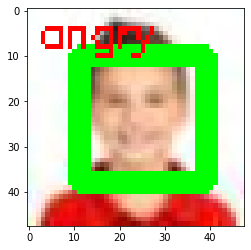

In [76]:
image_shrp=cv2.imread("Sharpness/blurred-image.jpeg")
predicted=DeepFace.analyze(image_shrp)
annotate(image_shrp)
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(image_shrp,
            predicted['dominant_emotion'],
            (2,8),
            font, 0.3,
            (0,0,255),
            0,);
plt.imshow(cv2.cvtColor(image_shrp, cv2.COLOR_BGR2RGB))

#### Sharpness: Using Deepface for More Sharper Images

Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Action: age:   0%|          | 0/4 [00:00<?, ?it/s]    

1/1 [==============================] - 1s 636ms/step


Action: gender:  50%|█████     | 2/4 [00:00<00:00,  2.64it/s]

1/1 [==============================] - 1s 640ms/step


Action: race:  75%|███████▌  | 3/4 [00:01<00:00,  1.96it/s]  

1/1 [==============================] - 1s 636ms/step


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Number of faces detected: 1
Number of eyes detected: 0


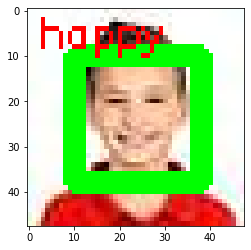

In [77]:
image_shrp1=cv2.imread("Sharpness/sharpened-image.jpeg")
predicted=DeepFace.analyze(image_shrp1)
annotate(image_shrp1)
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(image_shrp1,
            predicted['dominant_emotion'],
            (2,8),
            font, 0.3,
            (0,0,255),
            0,);
plt.imshow(cv2.cvtColor(image_shrp1, cv2.COLOR_BGR2RGB))

---
##  Manipulating the images using PIL (pillow) and Predicting the Emotions For CNN
---

### Resizing the Image to 48 * 48

In [20]:
image = Image.open('Images/angry.jpg')
new_image = image.resize((48, 48))
new_image.save('Images/myimage_cnn.jpeg')

### Adjusting the brightness of the image

#### Now, we will brighten the image with a factor of 1, which gives our original image. Then with a factor of 1.5, which gives a brightened image. And then with a factor of 0.5, which gives a darkened image.

In [27]:
from PIL import Image, ImageEnhance

#read the image
image = Image.open("Images/myimage_cnn.jpeg")

#image brightness enhancer
enhancer = ImageEnhance.Brightness(image)

factor = 1 #gives original image
image_output = enhancer.enhance(factor)
image_output.save('Brightness/original-image_cnn.jpeg')

factor = 0.5 #darkens the image
image_output = enhancer.enhance(factor)
image_output.save('Brightness/darkened-image_cnn.jpeg')

factor = 1.5 #brightens the image
image_output = enhancer.enhance(factor)
image_output.save('Brightness/brightened-image_cnn.jpeg')

### Adjusting the contrast of the image


#### Now, we will change the image contrast with a factor of 1, which gives our original image. Then with a factor of 1.5, which increases the image’s contrast. And then with a factor of 0.5, which greys out the image.

In [28]:
#read the image
image = Image.open("Images/myimage_cnn.jpeg")

#image brightness enhancer
enhancer = ImageEnhance.Contrast(image)

factor = 1 #gives original image
image_output = enhancer.enhance(factor)
image_output.save('Contrast/original-image_cnn.jpeg')

factor = 0.5 #decrease constrast
image_output = enhancer.enhance(factor)
image_output.save('Contrast/less-contrast-image_cnn.jpeg')

factor = 1.5 #increase contrast
image_output = enhancer.enhance(factor)
image_output.save('Contrast/more-contrast-image_cnn.jpeg')

### Adjusting the sharpness of the image

#### Now, we will sharpen the image with a factor of 1, which gives our original image. Then with a factor of 2, which gives a sharpened image. And then with a factor of 0.05, which gives a blurred image.

In [29]:
from PIL import Image, ImageEnhance

image = Image.open("Images/myimage_cnn.jpeg")

enhancer = ImageEnhance.Sharpness(image)

factor = 1
image_s_1 = enhancer.enhance(factor)
image_s_1.save('Sharpness/original-image-1_cnn.jpeg');

factor = 0.05
image_s_1 = enhancer.enhance(factor)
image_s_1.save('Sharpness/blurred-image_cnn.jpeg');

factor = 2
image_s_1 = enhancer.enhance(factor)
image_s_1.save('Sharpness/sharpened-image_cnn.jpeg');

## Checking all the Manipulated Images with CNN
---

### Brightness
---

#### Brightness: Using CNN for Less Brightened Images

In [48]:
from tensorflow.keras.utils import img_to_array

1/1 [==============================] - 0s 16ms/step


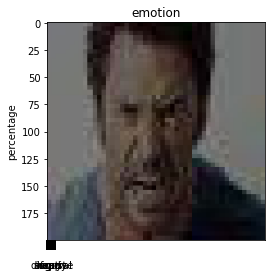

Expression Prediction: sad


In [49]:
from skimage import io
_img_ = load_img('Brightness/darkened-image_cnn.jpeg', grayscale=True, target_size=(48, 48))
show_img=load_img('Brightness/darkened-image_cnn.jpeg', grayscale=False, target_size=(200, 200))
m = img_to_array(_img_)
m = np.expand_dims(m, axis = 0)

m /= 255

custom = modeling.predict(m)
#print(custom[0])
emotion_analysis(custom[0])

m = np.array(m, 'float32')
m = m.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

decimal=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>decimal:
        decimal=a[i]
        ind=i
        
print('Expression Prediction:',objct[ind])

#### Brightness: Using CNN for More Brightened Images

1/1 [==============================] - 0s 19ms/step


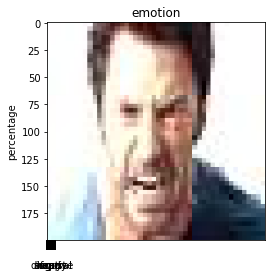

Expression Prediction: angry


In [50]:
from skimage import io
_img_ = load_img('Brightness/brightened-image_cnn.jpeg', grayscale=True, target_size=(48, 48))
show_img=load_img('Brightness/brightened-image_cnn.jpeg', grayscale=False, target_size=(200, 200))
m = img_to_array(_img_)
m = np.expand_dims(m, axis = 0)

m /= 255

custom = modeling.predict(m)
#print(custom[0])
emotion_analysis(custom[0])

m = np.array(m, 'float32')
m = m.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

decimal=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>decimal:
        decimal=a[i]
        ind=i
        
print('Expression Prediction:',objct[ind])

## Contrast
---

#### Contrast: Using CNN for Less Contrast Images

1/1 [==============================] - 0s 19ms/step


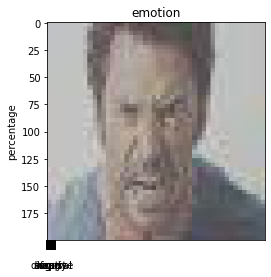

Expression Prediction: fear


In [51]:
from skimage import io
_img_ = load_img('Contrast/less-contrast-image_cnn.jpeg', grayscale=True, target_size=(48, 48))
show_img=load_img('Contrast/less-contrast-image_cnn.jpeg', grayscale=False, target_size=(200, 200))
m = img_to_array(_img_)
m = np.expand_dims(m, axis = 0)

m /= 255

custom = modeling.predict(m)
#print(custom[0])
emotion_analysis(custom[0])

m = np.array(m, 'float32')
m = m.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

decimal=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>decimal:
        decimal=a[i]
        ind=i
        
print('Expression Prediction:',objct[ind])

#### Contrast: Using CNN for More Contrast Images

1/1 [==============================] - 0s 15ms/step


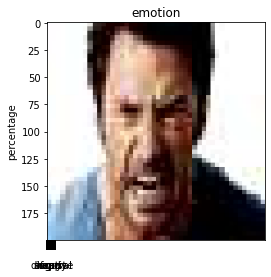

Expression Prediction: angry


In [52]:
from skimage import io
_img_ = load_img('Contrast/more-contrast-image_cnn.jpeg', grayscale=True, target_size=(48, 48))
show_img=load_img('Contrast/more-contrast-image_cnn.jpeg', grayscale=False, target_size=(200, 200))
m = img_to_array(_img_)
m = np.expand_dims(m, axis = 0)

m /= 255

custom = modeling.predict(m)
#print(custom[0])
emotion_analysis(custom[0])

m = np.array(m, 'float32')
m = m.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

decimal=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>decimal:
        decimal=a[i]
        ind=i
        
print('Expression Prediction:',objct[ind])

## Sharpness
---

#### Sharpness: Using Deepface for Less Sharper Images

1/1 [==============================] - 0s 15ms/step


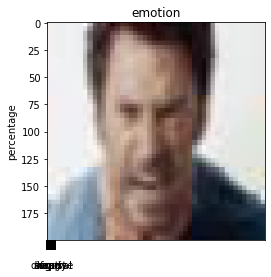

Expression Prediction: fear


In [53]:
from skimage import io
_img_ = load_img('Sharpness/blurred-image_cnn.jpeg', grayscale=True, target_size=(48, 48))
show_img=load_img('Sharpness/blurred-image_cnn.jpeg', grayscale=False, target_size=(200, 200))
m = img_to_array(_img_)
m = np.expand_dims(m, axis = 0)

m /= 255

custom = modeling.predict(m)
#print(custom[0])
emotion_analysis(custom[0])

m = np.array(m, 'float32')
m = m.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

decimal=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>decimal:
        decimal=a[i]
        ind=i
        
print('Expression Prediction:',objct[ind])

#### Sharpness: Using Deepface for More Sharper Images

1/1 [==============================] - 0s 19ms/step


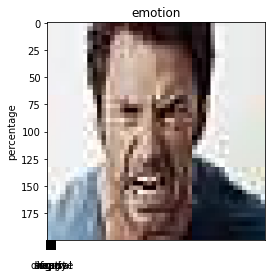

Expression Prediction: angry


In [54]:
from skimage import io
_img_ = load_img('Sharpness/sharpened-image_cnn.jpeg', grayscale=True, target_size=(48, 48))
show_img=load_img('Sharpness/sharpened-image_cnn.jpeg', grayscale=False, target_size=(200, 200))
m = img_to_array(_img_)
m = np.expand_dims(m, axis = 0)

m /= 255

custom = modeling.predict(m)
#print(custom[0])
emotion_analysis(custom[0])

m = np.array(m, 'float32')
m = m.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

decimal=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>decimal:
        decimal=a[i]
        ind=i
        
print('Expression Prediction:',objct[ind])